In [1]:
# Importación de librerías y carga de datos
import pandas as pd

# Cargar productos
productos = pd.read_csv('datos/productos.csv')
# Cargar ventas
ventas = pd.read_csv('datos/ventas.csv')

# Vista previa de los datos
display(productos.head())
display(ventas.head())

,codigo_barras,descripcion,marca,proveedor,contenido
0,7730197008076,"AGUA SABORIZADA AQUARIUS MANZANA 1,5L",AQUARIUS,MONTEVIDEO REFRESCOS S.R.L.,1500
1,7730197008597,"AGUA SABORIZADA AQUARIUS NARANJA 1,5L",AQUARIUS,MONTEVIDEO REFRESCOS S.R.L.,1500
2,7730197008006,"AGUA SABORIZADA AQUARIUS PERA 1,5L",AQUARIUS,MONTEVIDEO REFRESCOS S.R.L.,1500
3,7734284001913,"AGUA SABORIZADA H2OH! CITRUS 1,5L",H2OH!,FNC S.A.,1500
4,7734284001185,"AGUA SABORIZADA H2OH! LIMA LIMON 1,5L",H2OH!,FNC S.A.,1500


,fecha_comercial,pdv_codigo,codigo_barras,imp_vta,cant_vta
0,2020-06-02,514,7730400001518,69.0,1
1,2020-06-17,8155,7734284001157,70.0,1
2,2020-06-11,7604,7730400003002,77.0,1
3,2020-06-02,3207,7734284001913,70.0,1
4,2020-06-07,8008,7730400001835,84.0,1


Obtener la lista de productos que se venden en al menos el 80% de los puntos de venta.

In [2]:
sku_80_pdv = (ventas
    # 1) Añadir la cuenta distinta de pdv por sku en una columna adicional
    .assign(
        n_tiendas_por_sku=lambda df: df
            .groupby('codigo_barras')['pdv_codigo']
            .transform('nunique')
    )
    # 2) n tiendas totales
    .assign(
        n_tiendas_totales=lambda df: df['pdv_codigo'].nunique()
    )
    # 3) Calcular el porcentaje de cobertura de pdv por sku
    .assign(
        porcentaje_cobertura=lambda df: df['n_tiendas_por_sku'] / df['n_tiendas_totales'] * 100
    )
    # 4) Filtrar productos con al menos 80% de cobertura de pdv
    .query('porcentaje_cobertura >= 80')
    .rename(columns={'codigo_barras': 'sku'})
    # 5) lista de skus con al menos 80% de cobertura de pdv
    .sku
    .drop_duplicates()
    .reset_index(drop=True)
)

sku_80_pdv.to_frame()

# siempre crear un test unitario para verificar que el resultado es correcto

,sku
0,7730400003002
1,7730400001835
2,7730400003480
3,7730400003920
4,7730400003300
5,7730400001707
6,7730400003980
7,7730400003432


Ordenar los productos de mayor a menor según su venta en volumen medido litros (suma de los 6 meses) y
quedarse con los que acumulan el 80% (Pareto).

In [3]:
# algunas precondiciones: verificar que sean 6 meses de transaccionalidad por producto
ventas['fecha_comercial'] = pd.to_datetime(ventas['fecha_comercial'])
ventas['month_year'] = ventas['fecha_comercial'].dt.to_period('M')

assert ventas['month_year'].nunique() == 6, "Debe haber exactamente 6 meses de transacciones por producto"
assert ventas['month_year'].min() == ventas['month_year'].max() - 5, "Los meses deben ser consecutivos"

# Calcular la fecha de corte (6 meses atrás)
fecha_corte = pd.Timestamp.now() - pd.DateOffset(months=6)

sku_80_vol = (ventas
    # 1) Añadir la columna de mililitros de cada producto a la tabla de ventas
    .merge(productos[['codigo_barras', 'contenido']], on='codigo_barras', how='left')
    # 2) Calcular el volumen de ventas por producto
    .assign(
        volumen_vendido=lambda df: df['contenido'] * df['cant_vta']/ 1000  # convertir a litros
    )
    # 3) Convertir fecha_comercial a datetime antes de filtrar
    .assign(fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']))
    # 4) Calcular el volumen total vendido por producto en los últimos 6 meses
    .groupby('codigo_barras', as_index=False)
    .agg(
        volumen_total_vendido=('volumen_vendido', 'sum'),
    )
    # 5) ordenar por volumen total vendido de forma descendente
    .sort_values(by='volumen_total_vendido', ascending=False)
    # 6) Agregar una columna con el volumen total
    .assign(
        volumen_total=lambda df: df['volumen_total_vendido'].sum()
    )
    # 7) Calcular el porcentaje de volumen vendido por producto
    .assign(
        porcentaje_volumen=lambda df: df['volumen_total_vendido'] / df['volumen_total'] * 100
    )
    # 8) Calcular la suma acumulada del porcentaje de volumen vendido
    .assign(
        porcentaje_acumulado=lambda df: df['porcentaje_volumen'].cumsum()
    )
    # 9) Filtrar productos que están en el top 80% del volumen vendido
    .query('porcentaje_acumulado <= 80')
    # 10) renombrar columna codigo_barras a sku
    .rename(columns={'codigo_barras': 'sku'})
    # 11) resetear el índice
    .reset_index(drop=True)
    # 12) lista de skus en el top 80% del volumen vendido
    .sku
)

sku_80_vol

0     7730400003300
1     7730400003920
2     7730400001707
3     7730400001247
4     7730400003980
5     7730400003432
6     7730400003480
7     7730400001835
8     7730400001161
9     7730400003002
10    7730400001518
11    7734284001157
12    7734284001766
Name: sku, dtype: int64

Obtener para cada producto el identificador (pdv_codigo) de uno cualquiera de los puntos de venta que lo vende
con mayor frecuencia.

(pregunta 1) Considerar solamente los productos que están presentes en al menos el 80% de los puntos de venta  

(pregunta 2) y en el top 80% de la venta en volumen .

Para el cálculo de la frecuencia considerar solamente los días que el punto de venta estuvo abierto (tuvo alguna
venta). Por ejemplo, si un producto en un punto de venta se vende todos los días de lunes a sábado y el punto de
venta está cerrado los domingos, la frecuencia tiene que ser cada 1 día

In [4]:
def fill_days_with_zero(df):
    """
    Rellena los días faltantes en el dataframe con ceros para las ventas.
    Asume que el dataframe tiene una columna 'fecha_comercial' y agrupa por 'pdv_codigo' y 'codigo_barras'.
    """
    # Asegurarse de que el dataframe tiene las columnas necesarias y sean únicas
    assert len(df['pdv_codigo'].unique()) == 1, "El dataframe debe tener un solo pdv_codigo"
    assert len(df['codigo_barras'].unique()) == 1, "El dataframe debe tener un solo codigo_barras"

    pdv_codigo = df['pdv_codigo'].unique()[0]
    codigo_barras = df['codigo_barras'].unique()[0]

    # Ensure fecha_comercial is datetime before creating date range
    df['fecha_comercial'] = pd.to_datetime(df['fecha_comercial'])
    
    complete_dates = pd.date_range(start=df['fecha_comercial'].min(), end=df['fecha_comercial'].max())
    complete_dates = pd.DataFrame(complete_dates, columns=['fecha_comercial'])

    # Keep fecha_comercial as datetime for consistent merging
    # No need to convert to string format

    # left join del rango de fechas con el dataframe
    df_complete = df.merge(complete_dates, on='fecha_comercial', how='right')

    df_complete["pdv_codigo"] = df_complete["pdv_codigo"].fillna(pdv_codigo)
    df_complete["codigo_barras"] = df_complete["codigo_barras"].fillna(codigo_barras)

    # pdv_codigo, codigo_barras as int
    df_complete['pdv_codigo'] = df_complete['pdv_codigo'].astype(int)
    df_complete['codigo_barras'] = df_complete['codigo_barras'].astype(int)

    # fill NoN with 0
    df_complete['cant_vta'] = df_complete['cant_vta'].fillna(0)
    df_complete['imp_vta'] = df_complete['imp_vta'].fillna(0)

    return df_complete

# dias validos de ventas para cada pdv
dias_vendas_validos = (
    ventas
    # 1) Convertir fecha_comercial a datetime
    .assign(fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']))
    # 2) Eliminar los dias sin ventas
    .query('cant_vta > 0')
    # 3) Agregar columna con el dia de la semana
    .assign(dia_semana=lambda df: df['fecha_comercial'].dt.day_name())
    # 4) Seleccionar las columnas relevantes: pdv_codigo, dia_semana
    [['pdv_codigo', 'dia_semana']]
    # 5) Eliminar duplicados
    .drop_duplicates()
)

ventas_80_pdv = ventas[ventas['codigo_barras'].isin(sku_80_pdv)]

# pregunta 1: productos con al menos 80% de cobertura de PDV
(ventas_80_pdv
    # 1) Convertir fecha_comercial a datetime al inicio
    .assign(fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']))
    # 2) Agregar fechas faltantes en el rango de fechas de cada pdv
    .groupby(['pdv_codigo', 'codigo_barras'], as_index=False)
    .apply(fill_days_with_zero, include_groups=True)
    .reset_index(drop=True)
    # 3) extraer el dia de la semana
    .assign(dia_semana=lambda df: df['fecha_comercial'].dt.day_name())
    # 4) via inner join, agregar los dias validos de ventas para cada pdv
    .merge(dias_vendas_validos, on=['pdv_codigo', 'dia_semana'], how='inner')
    # 5) Eliminar agregar flag de ventas (1 si hay ventas, 0 si no hay ventas)
    .assign(sales_flag=lambda df: (df['cant_vta'] > 0).astype(int))
    # 6) Para cada sku y pdv, calcular la proporción de días con ventas
    #    (es decir, el ratio de días con ventas sobre el total de días válidos)
    .groupby(['codigo_barras', 'pdv_codigo'], as_index=False)
    .agg(
        ratio_dias_con_ventas=('sales_flag', 'mean')
    )
    # 7) Para cada sku, dar el pdv con el mayor ratio de días con ventas
    .sort_values(by=['codigo_barras', 'ratio_dias_con_ventas'], ascending=[True, False])
    .groupby('codigo_barras', as_index=False)
    .first()
)


/var/folders/dm/qfl9b82961d8nrqyqsyr5d800000gn/T/ipykernel_12939/2877554442.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_days_with_zero, include_groups=True)


,codigo_barras,pdv_codigo,ratio_dias_con_ventas
0,7730400001707,5306,1.0
1,7730400001835,72,1.0
2,7730400003002,181,1.0
3,7730400003300,99,1.0
4,7730400003432,26,1.0
5,7730400003480,247,1.0
6,7730400003920,54,1.0
7,7730400003980,72,1.0


In [5]:
# pregunta 2: básicamente la misma lógica que la pregunta 1, pero ahora con la data de volumen que viene litros
# que ya calculamos antes.

ventas_80_vol = ventas[ventas['codigo_barras'].isin(sku_80_vol)]
                 
(ventas_80_vol
    # 1) Convertir fecha_comercial a datetime al inicio
    .assign(fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']))
    # 2) Agregar fechas faltantes en el rango de fechas de cada pdv
    .groupby(['pdv_codigo', 'codigo_barras'], as_index=False)
    .apply(fill_days_with_zero, include_groups=True)
    .reset_index(drop=True)
    # 3) extraer el dia de la semana
    .assign(dia_semana=lambda df: df['fecha_comercial'].dt.day_name())
    # 4) via inner join, agregar los dias validos de ventas para cada pdv
    .merge(dias_vendas_validos, on=['pdv_codigo', 'dia_semana'], how='inner')
    # 5) Eliminar agregar flag de ventas (1 si hay ventas, 0 si no hay ventas)
    .assign(sales_flag=lambda df: (df['cant_vta'] > 0).astype(int))
    # 6) Para cada sku y pdv, calcular la proporción de días con ventas
    #    (es decir, el ratio de días con ventas sobre el total de días válidos)
    .groupby(['codigo_barras', 'pdv_codigo'], as_index=False)
    .agg(
        ratio_dias_con_ventas=('sales_flag', 'mean')
    )
    # 7) Para cada sku, dar el pdv con el mayor ratio de días con ventas
    .sort_values(by=['codigo_barras', 'ratio_dias_con_ventas'], ascending=[True, False])
    .groupby('codigo_barras', as_index=False)
    .first()
)

/var/folders/dm/qfl9b82961d8nrqyqsyr5d800000gn/T/ipykernel_12939/3506754026.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_days_with_zero, include_groups=True)


,codigo_barras,pdv_codigo,ratio_dias_con_ventas
0,7730400001161,72,1.0
1,7730400001247,247,1.0
2,7730400001518,72,1.0
3,7730400001707,5306,1.0
4,7730400001835,72,1.0
5,7730400003002,181,1.0
6,7730400003300,99,1.0
7,7730400003432,26,1.0
8,7730400003480,247,1.0
9,7730400003920,54,1.0


In [6]:
# Pregunta 4
# Calcula la variación porcentual de la venta de la categoría Aguas Saborizadas durante los meses de setiembre a
# noviembre, y comparalos con los meses de junio a agosto.

ventas_agua_saborizada = (ventas
 .merge(productos, on='codigo_barras', how='left')
 # 1) Filtrar por la columna tenga el substring 'Aguas Saborizadas' en la columna descripcion
 .query("descripcion.str.contains('AGUA SABORIZADA')")
 # 2) Agregar el nombre del mes
    .assign(fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']))
    .assign(mes=lambda df: df['fecha_comercial'].dt.to_period('M'))
)
import pandas as pd

# 1) Sumar ventas por mes
ventas_por_mes = (
    ventas_agua_saborizada
    .groupby('mes', as_index=False)['cant_vta']
    .sum()
    .rename(columns={'cant_vta':'ventas_totales'})
)

# 2) Definir los dos períodos
jun_ago = ventas_por_mes.loc[
    ventas_por_mes['mes'].dt.month.isin([6,7,8]),
    'ventas_totales'
].sum()

sep_nov = ventas_por_mes.loc[
    ventas_por_mes['mes'].dt.month.isin([9,10,11]),
    'ventas_totales'
].sum()

# 3) Calcular lift y variación %
lift = sep_nov / jun_ago
variacion_pct = (lift - 1) * 100

print(f"Ventas jun–ago: {jun_ago:,}")
print(f"Ventas sep–nov: {sep_nov:,}")
print(f"Lift     : {lift:.2f}")
print(f"Variación: {variacion_pct:.1f}%")

Ventas jun–ago: 125,197
Ventas sep–nov: 233,998
Lift     : 1.87
Variación: 86.9%


In [7]:
# Aunque es posible comparar variaciones porcentuales, hay que tener cuidado ya
# que grandes incrementos de ventas pequeñas pueden ser más significativos 
# que pequeños incrementos de ventas grandes. Por eso, es mejor comparar
# las variaciones porcentuales en el contexto de las ventas totales. Esta práctica
# se vuelve común al tener que reportar resultados de ventas a la alta gerencia, 
# para mostrar impacto de las acciones comenciales cuando realmente las cifras 
# no son tan significativas.

# Dado este disclaimer, vamos por las variaciones % de cada rango de meses
variacione_jun_ago = (
    ventas_por_mes
    # 1) Convertir el formato YYYY-MM a YYY-MM-01 para poder filtrar por mes
    .assign(mes=lambda df: pd.to_datetime(df['mes'].astype(str) + '-01'))
    # 2) Filtrar por los meses de junio a agosto
    .query("mes.dt.month.isin([6, 7, 8])")
    # 3) Calcular la variación porcentual respecto al mes de junio
    .assign(
        variacion_pct_jun_ago=lambda df: df.ventas_totales.pct_change().round(2) * 100
    )
    .rename(columns={'ventas_totales': 'ventas_jun_ago'})
    .reset_index(drop=True)
    .rename(columns={'mes': 'mes_jun_ago'})
    
)

display(variacione_jun_ago)

# Lo mismo para septiembre a noviembre
variacione_sep_nov = (
    ventas_por_mes
    # 1) Convertir el formato YYYY-MM a YYY-MM-01 para poder filter por mes
    .assign(mes=lambda df: pd.to_datetime(df['mes'].astype(str) + '-01'))
    # 2) Filtrar por los meses de septiembre a noviembre
    .query("mes.dt.month.isin([9, 10, 11])")
    # 3) Calcular la variación porcentual respecto al mes de septiembre
    .assign(    
        variacion_pct_sep_nov=lambda df: df.ventas_totales.pct_change().round(2) * 100
    )
    .reset_index(drop=True)
    .rename(columns={'mes': 'mes_sep_nov'})
)

display(variacione_sep_nov)

(variacione_jun_ago
 .join(variacione_sep_nov, how='outer')
 .assign(
        variacion_pct=lambda df: df['variacion_pct_sep_nov'] - df['variacion_pct_jun_ago']

 )
 )

,mes_jun_ago,ventas_jun_ago,variacion_pct_jun_ago
0,2020-06-01,27464,NaN
1,2020-07-01,29769,8.0
2,2020-08-01,67964,128.0


,mes_sep_nov,ventas_totales,variacion_pct_sep_nov
0,2020-09-01,70038,NaN
1,2020-10-01,78129,12.0
2,2020-11-01,85831,10.0


,mes_jun_ago,ventas_jun_ago,variacion_pct_jun_ago,mes_sep_nov,ventas_totales,variacion_pct_sep_nov,variacion_pct
0,2020-06-01,27464,NaN,2020-09-01,70038,NaN,NaN
1,2020-07-01,29769,8.0,2020-10-01,78129,12.0,4.0
2,2020-08-01,67964,128.0,2020-11-01,85831,10.0,-118.0


Insight clave:
Agosto mostró un crecimiento excepcional de +128 % sobre julio (ventas pasaron de 30 k a 68 k), 

mientras que en el siguiente período (octubre‐noviembre) el ritmo se moderó a tasas de +12 % y +10 % 

sobre sus meses precedentes, indicando la transición de un “boom” inicial a un ciclo de 

consolidación con crecimiento sostenido de un dígito.

## Pregunta 5
Identificar a partir de los datos proporcionados al menos una causa probable por la cual la venta de SALUS FRUTTE

CERO ANANA 1,65L ha crecido en el mes de setiembre.

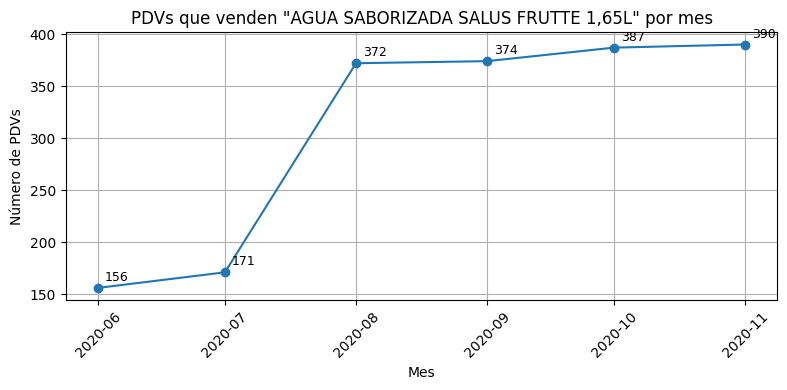

In [8]:

# variables
# pdv_mensual: DataFrame con la cantidad de PDVs que venden el SKU por mes
# sku_descripcion: Descripción del SKU a analizar
# ventas_7730400001707: DataFrame filtrado por el SKU específico


from matplotlib import pyplot as plt

sku_descripcion = 'AGUA SABORIZADA SALUS FRUTTE CERO ANANA 1,65L'
ventas_7730400001707 = (ventas
 .merge(productos, on='codigo_barras', how='left')
 # 1) Filtrar por la columna tenga el substring 'Aguas Saborizadas' en la columna descripcion
 .query("descripcion == @sku_descripcion")
)


# calculemos el número de pdv que venden este producto en cada fecha
(ventas_7730400001707
    .groupby(['fecha_comercial'], as_index=False)
    .agg(
        n_pdv=('pdv_codigo', 'nunique')
    )
    .sort_values(by='fecha_comercial')
    .reset_index(drop=True)
    .rename(columns={'fecha_comercial': 'date'})
    )

# graficar una serie de tiempo (mes) con la cantidad de pdv que venden este producto

# 1) Prepara los datos: convierte fecha a datetime y extrae el mes
pdv_mensual = (
    ventas_7730400001707
    .assign(
        fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']),
        mes=lambda df: df['fecha_comercial'].dt.to_period('M')
    )
    # 2) Para cada mes cuenta los PDV distintos que vendieron el SKU
    .groupby('mes', as_index=False)
    .agg(n_pdv=('pdv_codigo', 'nunique'))
    # 3) Convierte el PeriodIndex a datetime para plotear
    .assign(mes=lambda df: df['mes'].dt.to_timestamp())
)

# 4) Plotea la serie mensual
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(pdv_mensual['mes'], pdv_mensual['n_pdv'], marker='o', linestyle='-')
ax.grid(True)
ax.set_title('PDVs que venden "AGUA SABORIZADA SALUS FRUTTE 1,65L" por mes')
ax.set_xlabel('Mes')
ax.set_ylabel('Número de PDVs')
ax.xaxis.set_tick_params(rotation=45)

# Añadir etiquetas para cada punto
for i, row in pdv_mensual.iterrows():
    ax.annotate(f'{row["n_pdv"]}', 
                xy=(row['mes'], row['n_pdv']), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9)

plt.tight_layout()
plt.show()

Es decir, a mayor número de pdv que venden el producto hay un aumento de ventas. Es una correlación pero 
no sabemos aún si es efecto causal.


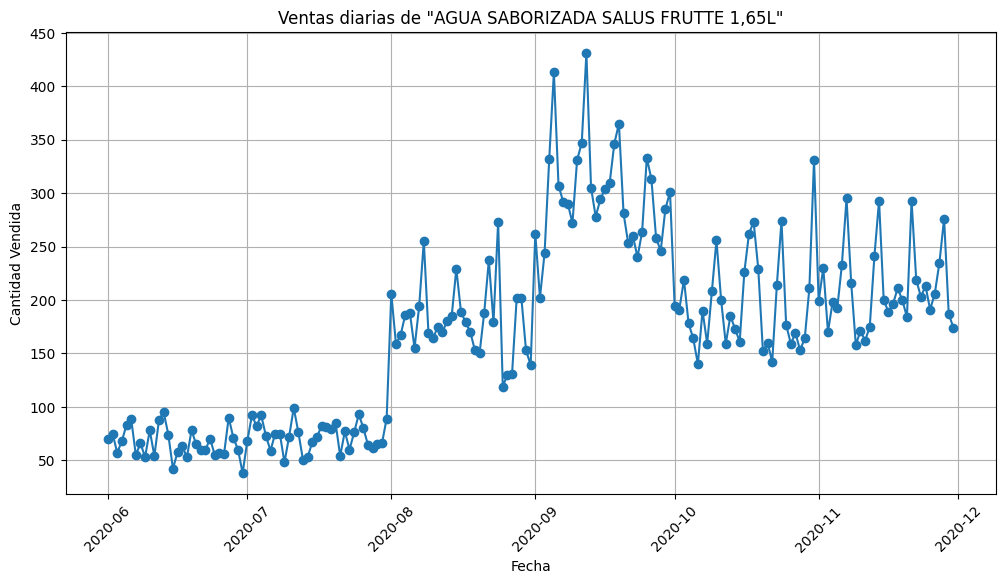

In [9]:
df_diario = (
    ventas_7730400001707
    .assign(
        fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']),
        dia=lambda df: df['fecha_comercial'].dt.to_period('D')
    )
    # 2) Para cada día cuenta los PDV distintos que vendieron el SKU
    .groupby('dia', as_index=False)
    .agg(cant_vta=('cant_vta', 'sum'),
    )
    .rename(columns={'dia': 'fecha_comercial'})
    # 3) Convert Period back to datetime for plotting
    .assign(fecha_comercial=lambda df: df['fecha_comercial'].dt.to_timestamp())
)
# 3) Plotea la serie diaria
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_diario['fecha_comercial'], df_diario['cant_vta'], marker
='o', linestyle='-')
ax.grid(True)
ax.set_title('Ventas diarias de "AGUA SABORIZADA SALUS FRUTTE 1,65L"')
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad Vendida')
ax.xaxis.set_tick_params(rotation=45)

plt.show()

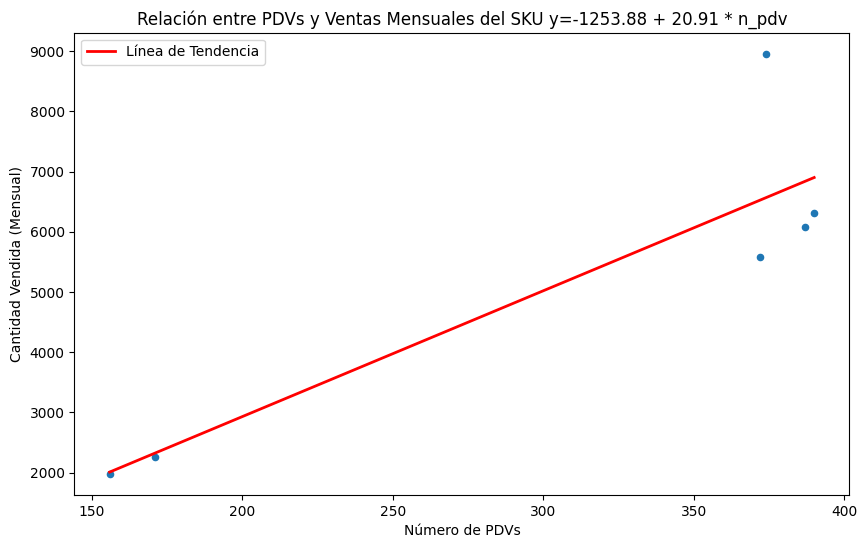

In [10]:
# HIPOTESIS: Un aumento en la cantidad de PDVs que venden un SKU genera un aumento proporcional en las ventas totales del SKU.
# Para verificar esta hipótesis, vamos a graficar la cantidad de PDVs que venden el SKU y las ventas totales del SKU.
# variables:
# df_diario: DataFrame con las ventas diarias del SKU
# pdv_mensual: DataFrame con la cantidad de PDVs que venden el SKU en cada mes
# df_vta_mensual: DataFrame con las ventas totales del SKU por mes
# df_merged: DataFrame que une pdv_mensual y df_vta_mensual


from sklearn.linear_model import LinearRegression
import numpy as np

# Agregar columna de mes a df_diario para poder hacer el merge
df_diario_con_mes = df_diario.assign(mes=lambda df: df['fecha_comercial'].dt.to_period('M'))

# Agregar ventas mensuales desde df_diario
df_vta_mensual = (df_diario_con_mes
    .groupby('mes', as_index=False)
    .agg(cant_vta_mensual=('cant_vta', 'sum'))
    .assign(mes=lambda df: df['mes'].dt.to_timestamp())
)

# Merge con pdv_mensual
df_merged = pdv_mensual.merge(df_vta_mensual, on='mes', how='inner')

# Agregar una línea de tendencia
X = df_merged['n_pdv'].values.reshape(-1, 1)
y = df_merged['cant_vta_mensual'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)


# agregar los coeficientes de la regresión lineal al centro del gráfico
slope = model.coef_[0][0]
intercept = model.intercept_[0]


# Crear el gráfico de dispersión
ax = df_merged.plot(
    x='n_pdv',
    y='cant_vta_mensual',
    kind='scatter',
    title=f'Relación entre PDVs y Ventas Mensuales del SKU y={intercept:.2f} + {slope:.2f} * n_pdv',
    xlabel='Número de PDVs',
    ylabel='Cantidad Vendida (Mensual)',
    figsize=(10, 6),
)

plt.plot(df_merged['n_pdv'], y_pred, color='red', linewidth=2, label='Línea de Tendencia')
plt.legend()
plt.show() 

se ve más claro que un crecimiento en los puntos de venta generan un aumento PROPORCIONAL en las ventas totales del sku.

Por otro lado también podemos calcular la venta en función del ticket promedio global del sku

para saber si existen efectos de elasticidad en la demanda, es decir, si en promedio el precio

del sku fue más bajo, cuánto varió la demanda.

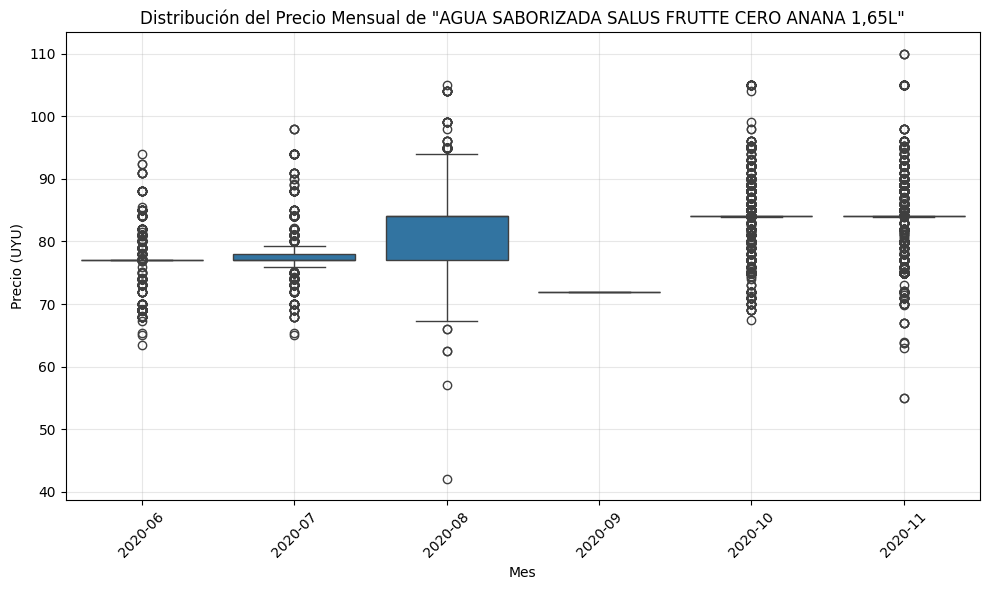

In [11]:
# Como los gráficos de precios siempre se ven distorcionados por los outliers, 
# es mejor usar un box plot de los logaritmos de los precios para ver la distribución 
# de los precios mensuales y poder comparar.

import seaborn as sns
# Calcular precio por unidad y crear box plot
ventas_7730400001707_precio = (ventas_7730400001707
    .assign(
        precio=lambda df: df['imp_vta'] / df['cant_vta'],
        log_precio=lambda df: np.log(df['imp_vta'] / df['cant_vta']),
        log_cant_vta=lambda df: np.log(df['cant_vta']),
        mes=lambda df: df['fecha_comercial'].dt.to_period('M').astype(str)
    )
)

# Crear box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=ventas_7730400001707_precio, x='mes', y='precio')
plt.title(f'Distribución del Precio Mensual de "{sku_descripcion}"')
plt.xlabel('Mes')
plt.ylabel('Precio (UYU)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Se ve que en septiembre (2020-09) una caida de precios el cual puede significar una estrategia de ventas
agresiva de precios lo que también puede explicar el pico de ventas en ese mes. 

### Es decir, las estrategias de precio sumadas al aumento de puntos de venta pueden 
### explicar la subida de ventas en septiembre.

<Axes: title={'center': 'Precio medio vs Ventas Diarias de "AGUA SABORIZADA SALUS FRUTTE CERO ANANA 1,65L"'}, xlabel='Precio Promedio', ylabel='venta total por pdv'>

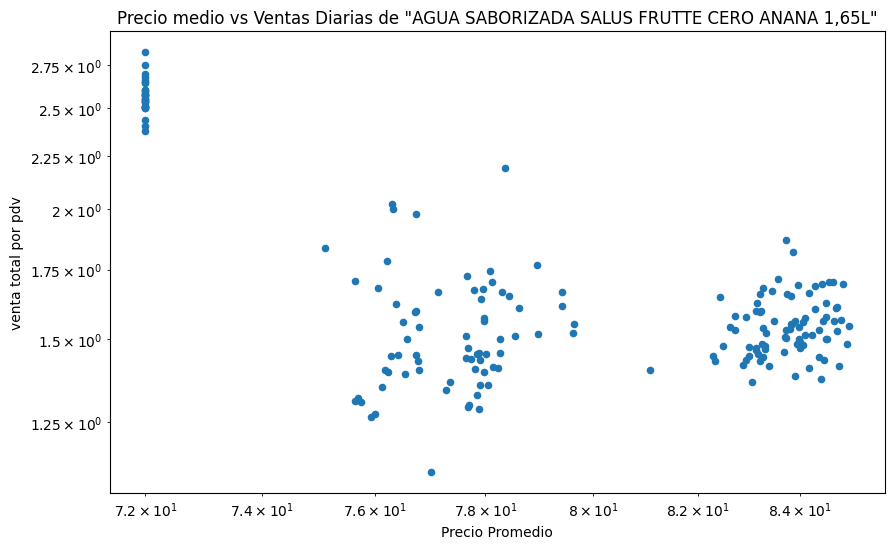

In [12]:
# para hacer en análisis de elasticidad de precios usaremos para cada día
# 1) el ticket promedio mensual
# 2) la cantidad total vendida
# 3) el número de puntos de venta de ese sku

(ventas_7730400001707
    .assign(
        fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']),
        ticket_promedio=lambda df: df['imp_vta'] / df['cant_vta'],
        precio=lambda df: df['imp_vta'] / df['cant_vta'],
    )
    .groupby('fecha_comercial', as_index=False)
    .agg(ticket_promedio_mensual=('precio', 'mean'),
         ventas_mensuales=('cant_vta', 'sum'),
         n_pdv=('pdv_codigo', 'nunique')
         )
    .assign(venta_por_pdv=lambda df: df['ventas_mensuales'] / df['n_pdv'])
    .plot.scatter(
        x='ticket_promedio_mensual',
        y='venta_por_pdv',
        marker='o',
        title=f'Precio medio vs Ventas Diarias de "{sku_descripcion}"',
        xlabel='Precio Promedio',
        ylabel='venta total por pdv',
        figsize=(10, 6),
        logx=True,
        logy=True
    )
)

### Pregunta 6
Utilizando los datos proporcionados de productos y ventas, determine la relación entre las ventas y los factores

relevantes en el dataset (como precios, puntos de venta, etc.). A partir de esta relación, calcule la sensibilidad de

las ventas ante cambios en los precios (elasticidades). Justifique las decisiones que tome durante el análisis.


In [32]:
# Esto en R es más simple porque en python las librerías no
# acompañan, así que crearé un archivo de R

# Algunos supuestos que vamos a considerar para el modelo de regresión lineal mixto:
# 1) El precio es un efecto fijo (no aleatorio)
# 1) Existe efecto de pdv (varianza explicada por la plaza - efecto aleatorio)
# 2) Existe efecto del producto (varianza explicada por producto - efecto aleatorio)
# 3) Existe efecto del tiempo (efecto calendario)
# 4) Las ventas cero son una condicion de border, por lo que no las vamos a considerar
# 5) Las ventas cero pueden ser datos censurados por quiebre de stock, por lo que no las vamos a considerar
# 6) Vamos a usar un modelo de regresión lineal mixto para modelar



# preprocesamiento de los datos
ventas_procesadas = (ventas
 # 1) Efecto calendario: extraer el mes y el numero de semana (dentro del mes)
 .assign(
     fecha_comercial=lambda df: pd.to_datetime(df['fecha_comercial']),
     mes=lambda df: df['fecha_comercial'].dt.month,
     semana_mes=lambda df: ((df['fecha_comercial'].dt.day - 1) // 7) + 1,
     precio =lambda df: df['imp_vta'] / df['cant_vta'],
     log_precio=lambda df: np.log(df['imp_vta'] / df['cant_vta']),
     log_cant_vta=lambda df: np.log(df['cant_vta']),
     pdv_codigo=lambda df: df['pdv_codigo'].astype('category'),
     codigo_barras=lambda df: df['codigo_barras'].astype('category'),
# 2) Agregar dia de la semana: lunes, martes, miércoles, jueves, viernes, sábado, domingo
     dia_semana=lambda df: df['fecha_comercial'].dt.day_name()
 )
)

ventas_procesadas.to_csv('datos/ventas_procesadas.csv', index=False)

In [33]:
ventas_procesadas

,fecha_comercial,pdv_codigo,codigo_barras,imp_vta,cant_vta,month_year,mes,semana_mes,precio,log_precio,log_cant_vta,dia_semana
0,2020-06-02,514,7730400001518,69.0,1,2020-06,6,1,69.0,4.234107,0.000000,Tuesday
1,2020-06-17,8155,7734284001157,70.0,1,2020-06,6,3,70.0,4.248495,0.000000,Wednesday
2,2020-06-11,7604,7730400003002,77.0,1,2020-06,6,2,77.0,4.343805,0.000000,Thursday
3,2020-06-02,3207,7734284001913,70.0,1,2020-06,6,1,70.0,4.248495,0.000000,Tuesday
4,2020-06-07,8008,7730400001835,84.0,1,2020-06,6,1,84.0,4.430817,0.000000,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...
242241,2020-11-18,663,7730400003920,84.0,1,2020-11,11,3,84.0,4.430817,0.000000,Wednesday
242242,2020-11-20,396,7730197008076,62.0,1,2020-11,11,3,62.0,4.127134,0.000000,Friday
242243,2020-11-26,3727,7734284001185,59.0,1,2020-11,11,4,59.0,4.077537,0.000000,Thursday
242244,2020-11-11,7817,7730400003432,504.0,6,2020-11,11,2,84.0,4.430817,1.791759,Wednesday
